In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Hotel-Property-Value-Dataset/sample_submission.csv
/kaggle/input/Hotel-Property-Value-Dataset/train.csv
/kaggle/input/Hotel-Property-Value-Dataset/test.csv


In [2]:
# Load and examine basic structure
train_df = pd.read_csv("/kaggle/input/Hotel-Property-Value-Dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/Hotel-Property-Value-Dataset/test.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 81 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       1200 non-null   int64  
 1   PropertyClass            1200 non-null   int64  
 2   ZoningCategory           1200 non-null   object 
 3   RoadAccessLength         977 non-null    float64
 4   LandArea                 1200 non-null   int64  
 5   RoadType                 1200 non-null   object 
 6   ServiceLaneType          75 non-null     object 
 7   PlotShape                1200 non-null   object 
 8   LandElevation            1200 non-null   object 
 9   UtilityAccess            1200 non-null   object 
 10  PlotConfiguration        1200 non-null   object 
 11  LandSlope                1200 non-null   object 
 12  District                 1200 non-null   object 
 13  NearbyTransport1         1200 non-null   object 
 14  NearbyTransport2        

(array([  3.,   9.,   4.,  53.,  45.,  99., 117., 148., 103., 109., 113.,
         61.,  53.,  55.,  39.,  35.,  32.,  22.,   9.,  17.,  15.,  12.,
          4.,   6.,   9.,   8.,   3.,   4.,   3.,   0.,   3.,   1.,   1.,
          0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 34900.,  49102.,  63304.,  77506.,  91708., 105910., 120112.,
        134314., 148516., 162718., 176920., 191122., 205324., 219526.,
        233728., 247930., 262132., 276334., 290536., 304738., 318940.,
        333142., 347344., 361546., 375748., 389950., 404152., 418354.,
        432556., 446758., 460960., 475162., 489364., 503566., 517768.,
        531970., 546172., 560374., 574576., 588778., 602980., 617182.,
        631384., 645586., 659788., 673990., 688192., 702394., 716596.,
        730798., 745000.]),
 <BarContainer object of 50 artists>)

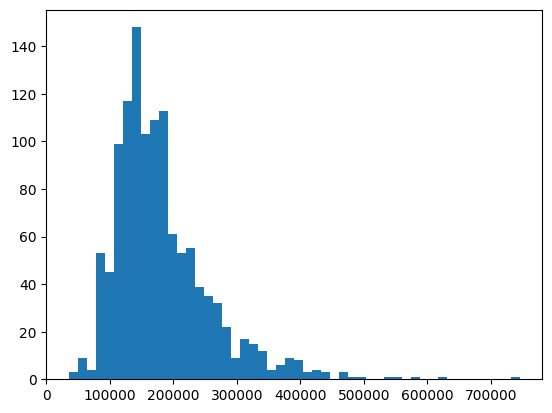

In [3]:
import matplotlib.pyplot as plt
plt.hist(train_df['HotelValue'], bins=50)

In [4]:
missing_summary = (
    train_df.isnull().sum() / len(train_df) * 100
).sort_values(ascending=False).to_frame("missing_percent")

# Add dtypes for reference
missing_summary["dtype"] = train_df.dtypes

# Focus only on numeric columns with some missingness
numeric_missing = missing_summary[
    (missing_summary["missing_percent"] > 0) &
    ((missing_summary["dtype"]=="float64") |
    (missing_summary["dtype"]=="int64"))
]

print(numeric_missing)

'''There are three features with missing values for numeric values.
The first is RoadAccessLength which is the length of road access available to the property. It could be that some properties do not have road
access at all, in which case we should fill 0 in all these columns, however we see that the column "RoadType" has no null values, which means 
every property has some road leading up to it. So the values are missing randomly, and not due to there being no road available. The missing
percentage is not very high (18.58%) so we can impute the values using median.'''

road_access_median = train_df["RoadAccessLength"].median()
train_df["RoadAccessLength"] = train_df["RoadAccessLength"].fillna(road_access_median)
test_df["RoadAccessLength"] = test_df["RoadAccessLength"].fillna(road_access_median)

'''FacadeArea only missing for rows with FacadeType null, we can impute 0 here as they probably have no facade.'''
train_df["FacadeArea"] = train_df["FacadeArea"].fillna(0)
test_df["FacadeArea"] = test_df["FacadeArea"].fillna(0)

'''ParkingConstructionYear imputed with median with ConstructionYear as there seems to be high correlation'''
train_df['ParkingConstructionYear'] = train_df['ParkingConstructionYear'].fillna(train_df['ConstructionYear'])
test_df['ParkingConstructionYear'] = test_df['ParkingConstructionYear'].fillna(test_df['ConstructionYear'])


                         missing_percent    dtype
RoadAccessLength               18.583333  float64
ParkingConstructionYear         5.416667  float64
FacadeArea                      0.583333  float64


Found 14 discrete numeric columns:


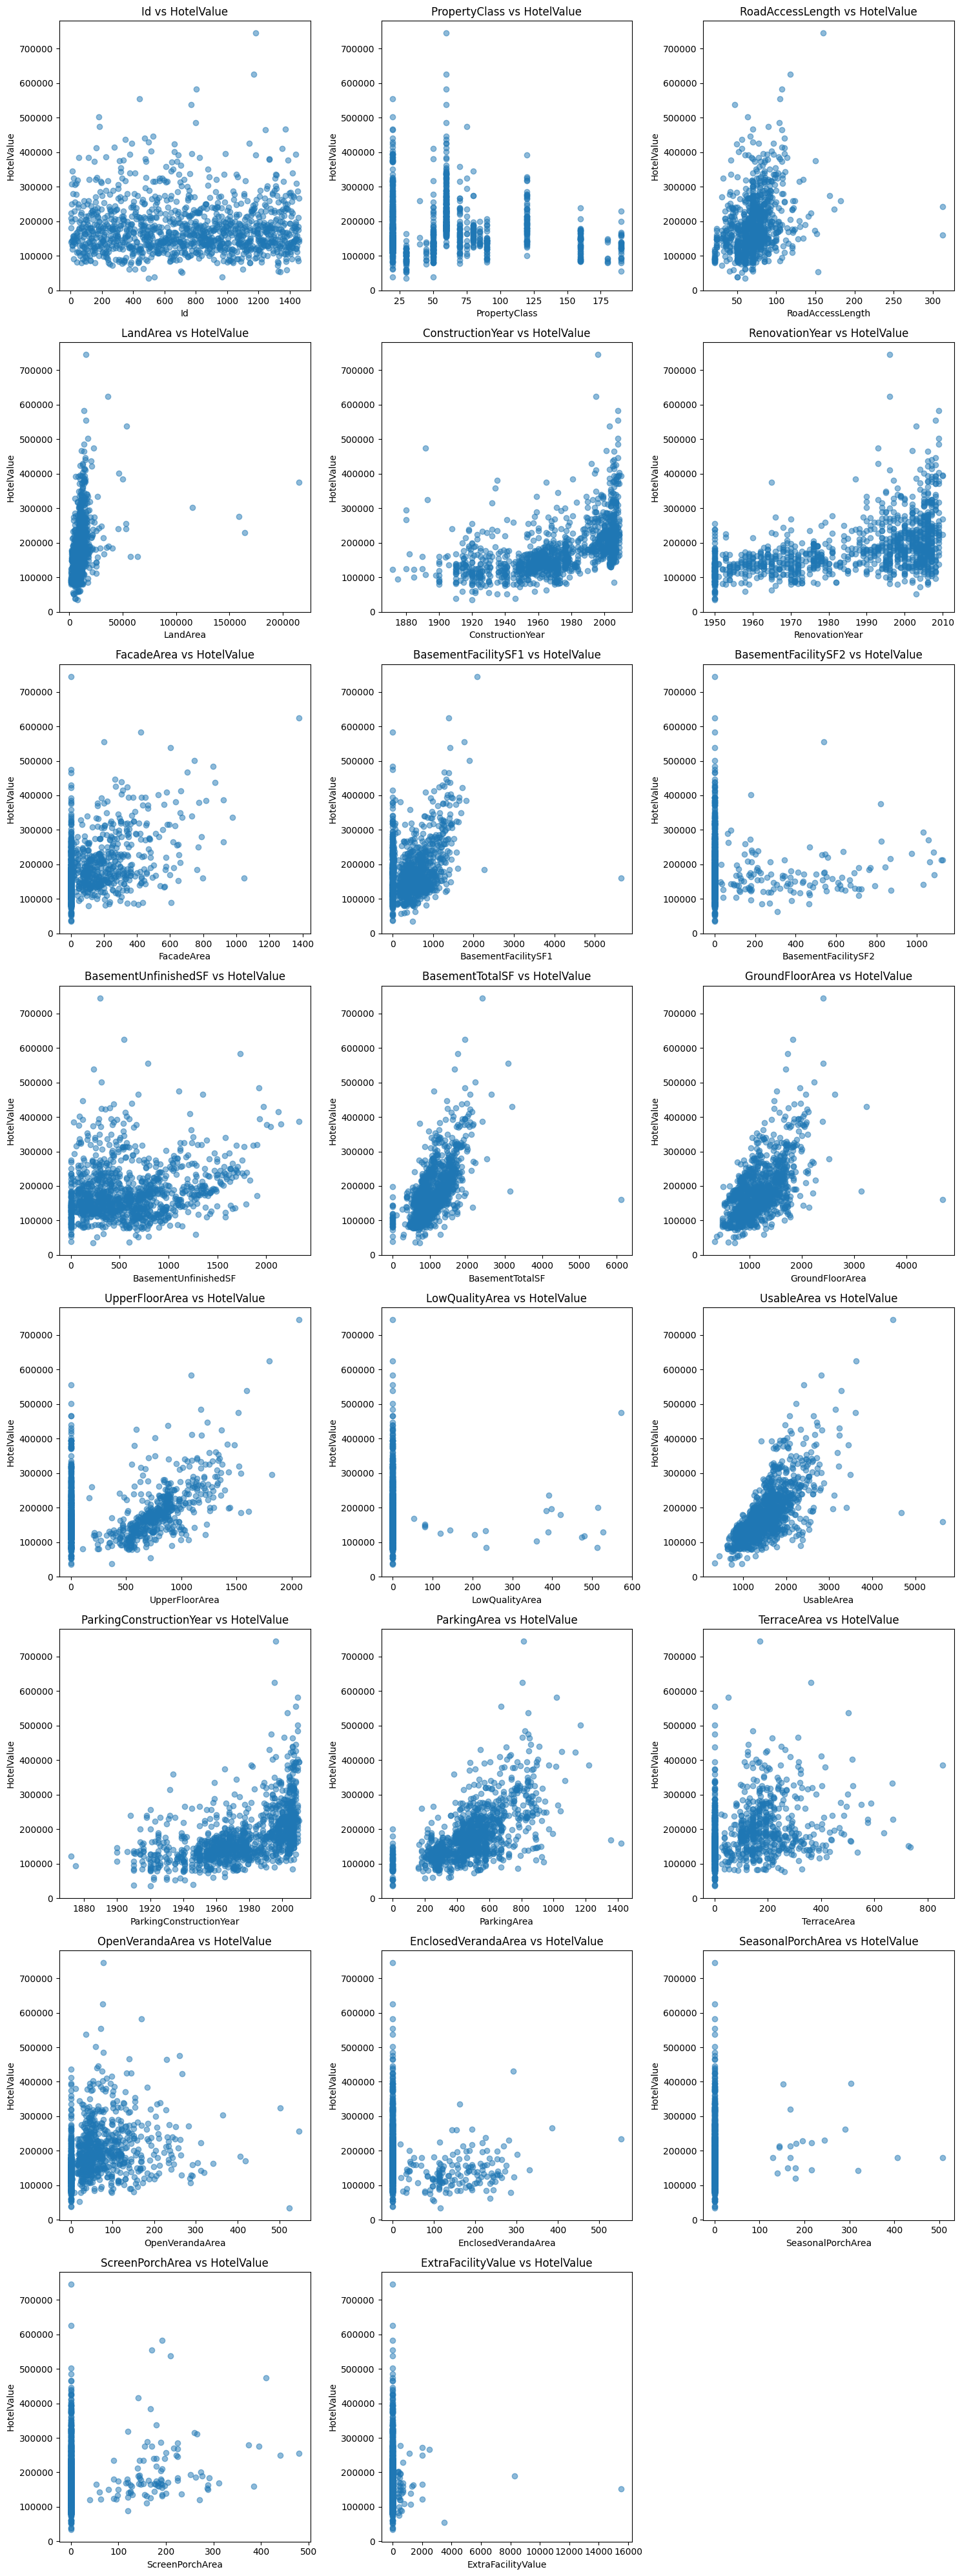

In [5]:
import math
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop('HotelValue')

nunique_threshold = 15
discrete_numeric_cols = []
for col in numeric_cols:
    if train_df[col].nunique() < nunique_threshold and col != 'HotelValue':
        discrete_numeric_cols.append(col)

print(f"Found {len(discrete_numeric_cols)} discrete numeric columns:")
continuous_numeric_cols = [
    col for col in numeric_cols 
    if train_df[col].nunique() >= nunique_threshold
]

# Dynamically determine the grid size for the subplots
n_cols = len(continuous_numeric_cols)
n_rows = math.ceil(n_cols / 3) # Creates a grid with 3 columns

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for idx, feature in enumerate(continuous_numeric_cols):
 axes[idx].scatter(train_df[feature], train_df['HotelValue'], alpha=0.5)
 axes[idx].set_xlabel(feature)
 axes[idx].set_ylabel('HotelValue')
 axes[idx].set_title(f'{feature} vs HotelValue')

# Hide any unused subplots
for i in range(n_cols, len(axes)):
 fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [6]:
'''Adding binary indicators for whether certain features exist for a house or not as there are a lot of facilities like terrace, parking
etc. which do not exist for quite a few houses.'''
# List all features with this pattern
area_features = ['EnclosedVerandaArea', 'SeasonalPorchArea', 'ScreenPorchArea', 
                 'TerraceArea', 'BasementTotalSF', 
                 'ParkingArea', 'OpenVerandaArea', 'FacadeArea', 'BasementFacilitySF1', 'BasementFacilitySF2', 
                 'BasementUnfinishedSF', 'UpperFloorArea', 'LowQualityArea', 'SwimmingPoolArea', 'ExtraFacilityValue']

for feature in area_features:
    train_df[f'Has{feature.replace("Area", "").replace("SF", "")}'] = (train_df[feature] > 0).astype(int)
    test_df[f'Has{feature.replace("Area", "").replace("SF", "")}'] = (test_df[feature] > 0).astype(int)

#SwimmingPoolArea and ExtraFacilityValue show hardly any correlation to the target variable even for houses that do have those facilities.
#Thus, these can be dropped.

train_df = train_df.drop(columns=['LowQualityArea', 'SeasonalPorchArea', 'ScreenPorchArea', 'SwimmingPoolArea', 'ExtraFacilityValue'])
test_df = test_df.drop(columns=['LowQualityArea', 'SeasonalPorchArea', 'ScreenPorchArea', 'SwimmingPoolArea', 'ExtraFacilityValue'])
print(train_df.shape)
print(test_df.shape)

(1200, 91)
(260, 90)


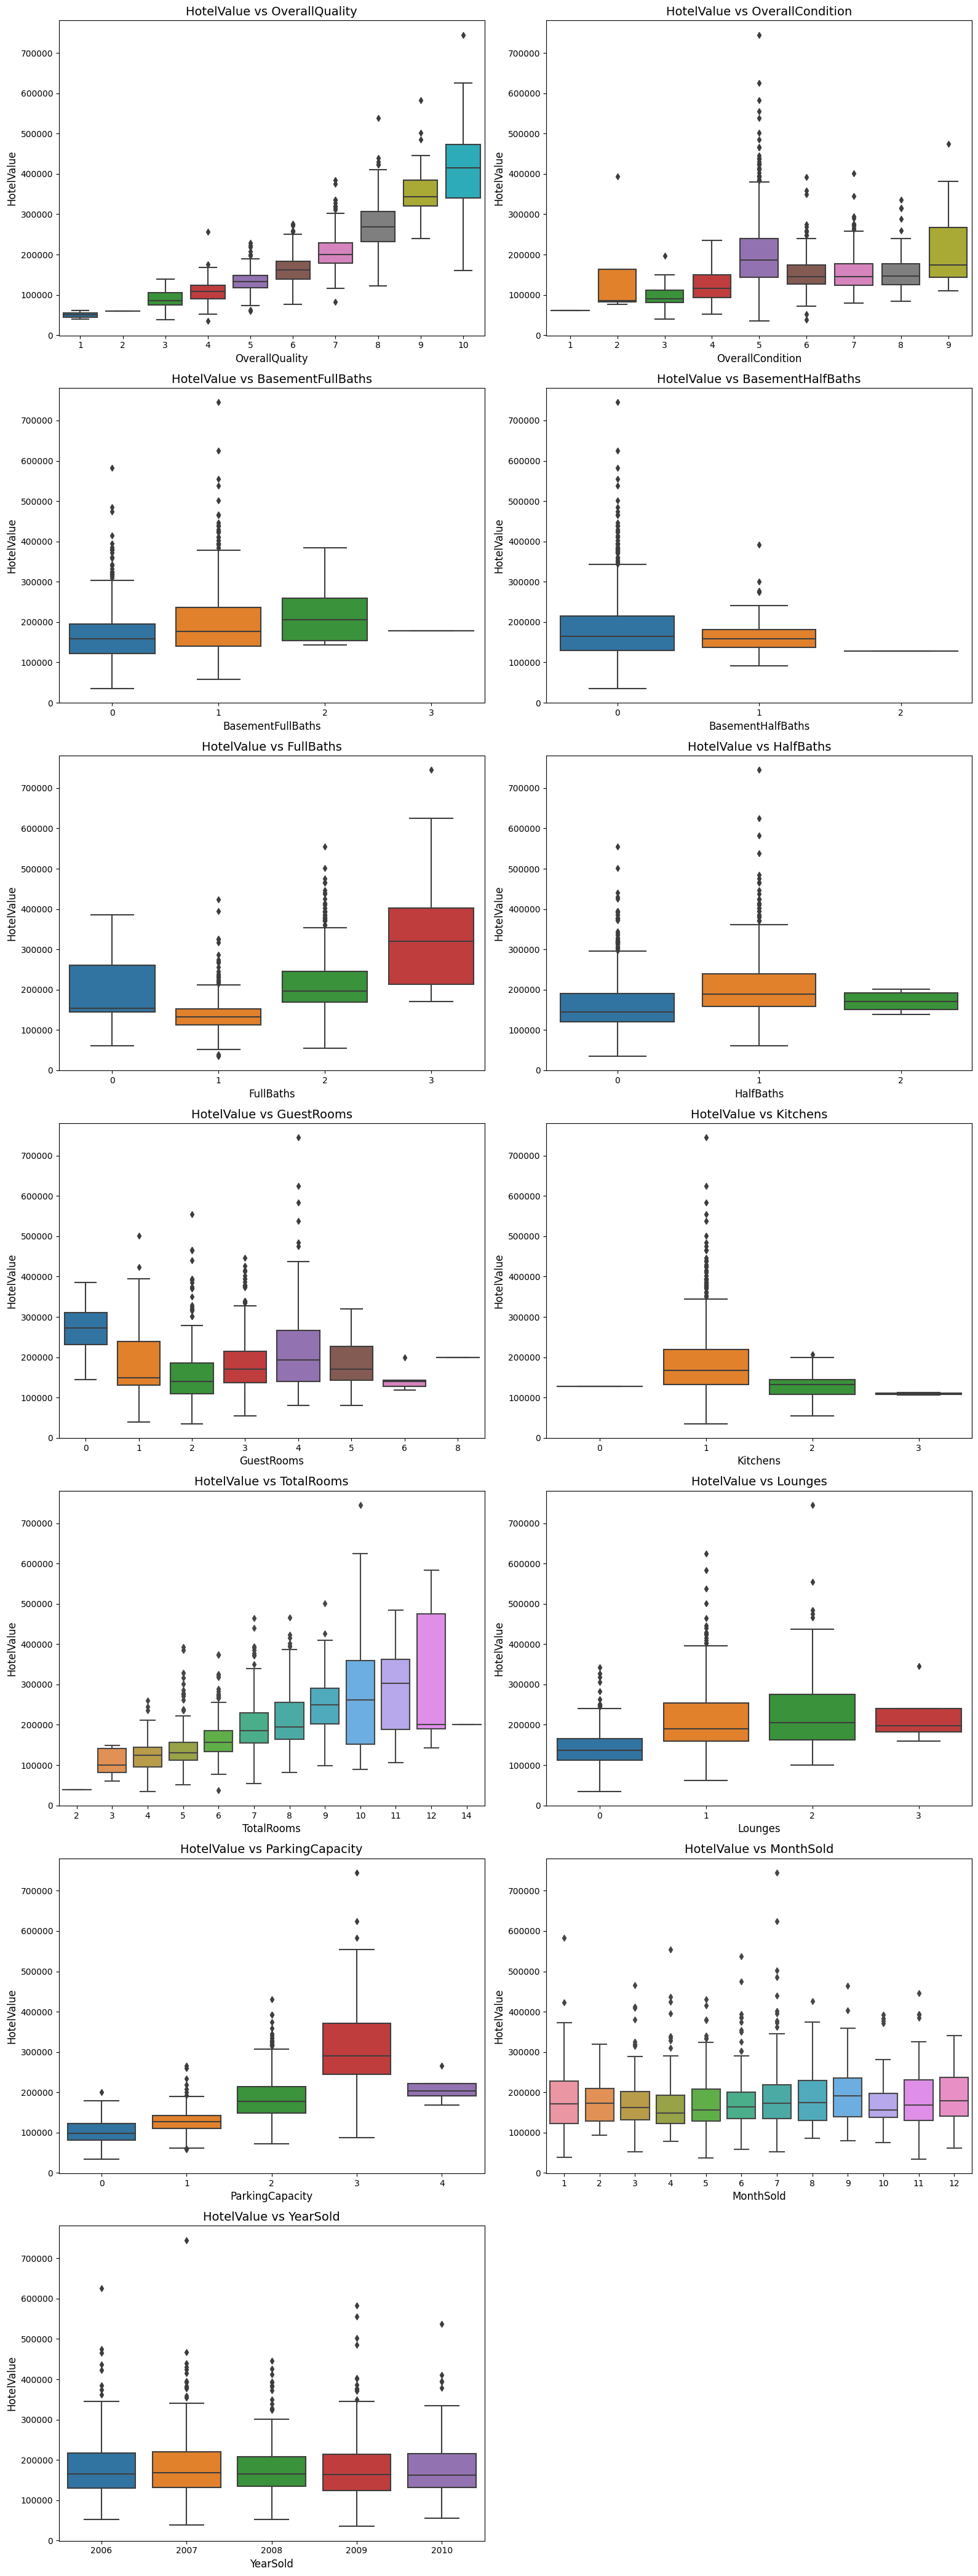

In [7]:
import seaborn as sns
discrete_numeric_cols.remove('SwimmingPoolArea')
n_features = len(discrete_numeric_cols)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Loop through the identified columns and create a boxplot for each
for idx, feature in enumerate(discrete_numeric_cols):
    sns.boxplot(x=feature, y='HotelValue', data=train_df, ax=axes[idx])
    axes[idx].set_title(f'HotelValue vs {feature}', fontsize=14)
    axes[idx].set_xlabel(feature, fontsize=12)
    axes[idx].set_ylabel('HotelValue', fontsize=12)

# Hide any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

In [8]:
#We will drop features which show very little variation across categories as these are unlikely to be string predictors of the target variable.
train_df = train_df.drop(columns=['MonthSold', 'BasementHalfBaths', 'YearSold'])
test_df = test_df.drop(columns=['MonthSold', 'BasementHalfBaths', 'YearSold'])

print(train_df.shape)
print(test_df.shape)

(1200, 88)
(260, 87)


In [9]:
categorical_missing = missing_summary[
    (missing_summary["missing_percent"] > 0) &
    (missing_summary["dtype"]=="object")    
]

print(categorical_missing)

#PoolQuality is missing for most rows, it can be dropped as it is unlikely to affect the data.
train_df = train_df.drop(columns=['PoolQuality'])
test_df = test_df.drop(columns=['PoolQuality'])

#The other missing features above 45% can be imputed as None. They are not missing randomly but because they do not exist cor that row.
#The parking features are only missing for rows with parking area=0, so they can be imputed with None too.
#In general the basement features are missing only for those rows with total basement area = 0. These can be imputed with None too.

none_imputation_cols = ['ExtraFacility', 'ServiceLaneType', 'BoundaryFence', 'FacadeType', 'LoungeQuality',
                        'ParkingCondition', 'ParkingType', 'ParkingFinish', 'ParkingQuality', 
                        'BasementExposure', 'BasementHeight', 'BasementCondition', 'BasementFacilityType1', 'BasementFacilityType2']
for col in none_imputation_cols:
    train_df[col] = train_df[col].fillna("None")
    test_df[col] = test_df[col].fillna("None")

#ElectricalSystem is null only for one row. It can be assumed that this is missing randomly, so can be imputed with the mode.
mode_value = train_df["ElectricalSystem"].mode()[0]
train_df["ElectricalSystem"] = train_df["ElectricalSystem"].fillna(mode_value)
test_df["ElectricalSystem"] = test_df["ElectricalSystem"].fillna(mode_value)

missing_counts = train_df.isnull().sum()
print(missing_counts[missing_counts > 0]) 

missing_counts_test = test_df.isnull().sum()
print(missing_counts_test[missing_counts_test > 0]) 


                       missing_percent   dtype
PoolQuality                  99.500000  object
ExtraFacility                96.166667  object
ServiceLaneType              93.750000  object
BoundaryFence                80.250000  object
FacadeType                   58.500000  object
LoungeQuality                46.666667  object
ParkingCondition              5.416667  object
ParkingType                   5.416667  object
ParkingFinish                 5.416667  object
ParkingQuality                5.416667  object
BasementExposure              2.500000  object
BasementHeight                2.416667  object
BasementCondition             2.416667  object
BasementFacilityType2         2.416667  object
BasementFacilityType1         2.416667  object
ElectricalSystem              0.083333  object
Series([], dtype: int64)
Series([], dtype: int64)


Found 42 columns with 'object' data type:


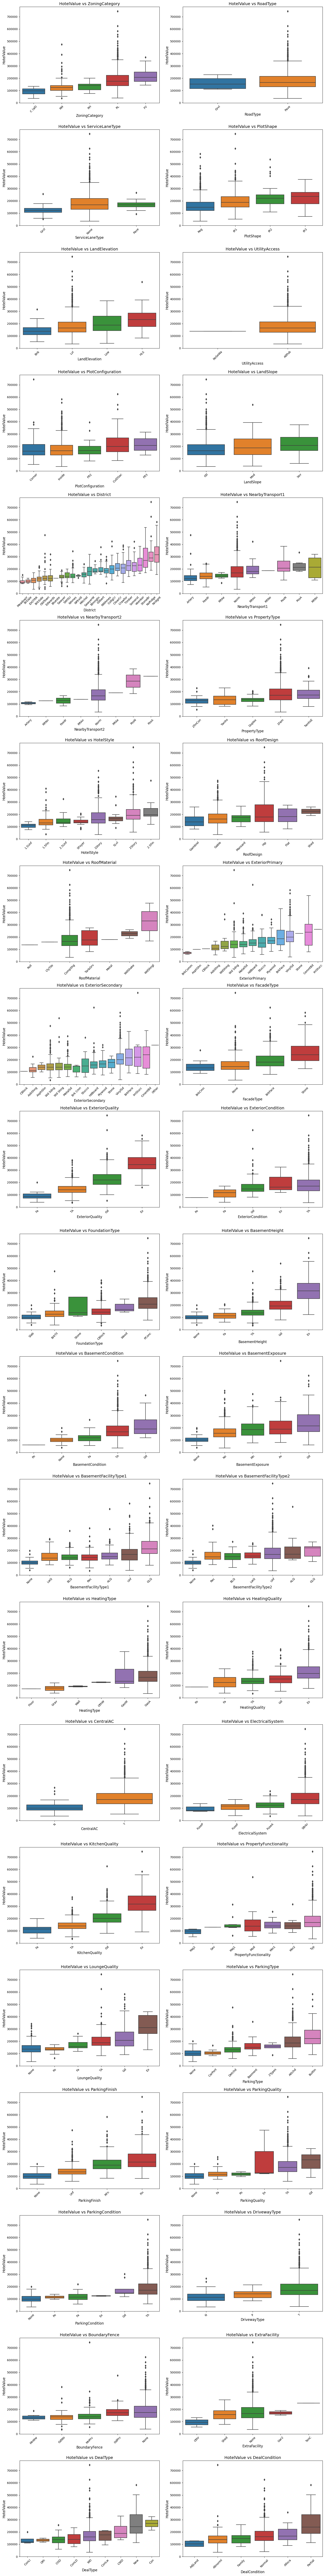

In [10]:
categorical_cols = train_df.select_dtypes(include=['object']).columns

print(f"Found {len(categorical_cols)} columns with 'object' data type:")
target_variable = 'HotelValue'

# Determine the grid size for the subplots (arranging them in 2 columns)
n_features = len(categorical_cols)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Loop through the identified columns and create a boxplot for each
for idx, feature in enumerate(categorical_cols):
    # It's good practice to sort the categories for a cleaner plot, e.g., by median value
    # This is optional but makes the plot easier to interpret
    sorted_order = train_df.groupby(feature)[target_variable].median().sort_values().index
    
    sns.boxplot(x=feature, y=target_variable, data=train_df, ax=axes[idx], order=sorted_order)
    
    axes[idx].set_title(f'{target_variable} vs {feature}', fontsize=14)
    axes[idx].set_xlabel(feature, fontsize=12)
    axes[idx].set_ylabel(target_variable, fontsize=12)
    
    # Optional: Rotate x-axis labels if they are long and overlap
    axes[idx].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

In [11]:
#We will drop columns with very little variance across categories
train_df = train_df.drop(columns=['UtilityAccess', 'RoadType'])
test_df = test_df.drop(columns=['UtilityAccess', 'RoadType'])

print(train_df.shape)
print(test_df.shape)

(1200, 85)
(260, 84)


Negative values per column:
 Series([], dtype: int64)
Infinite values per column:
 Series([], dtype: int64)


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


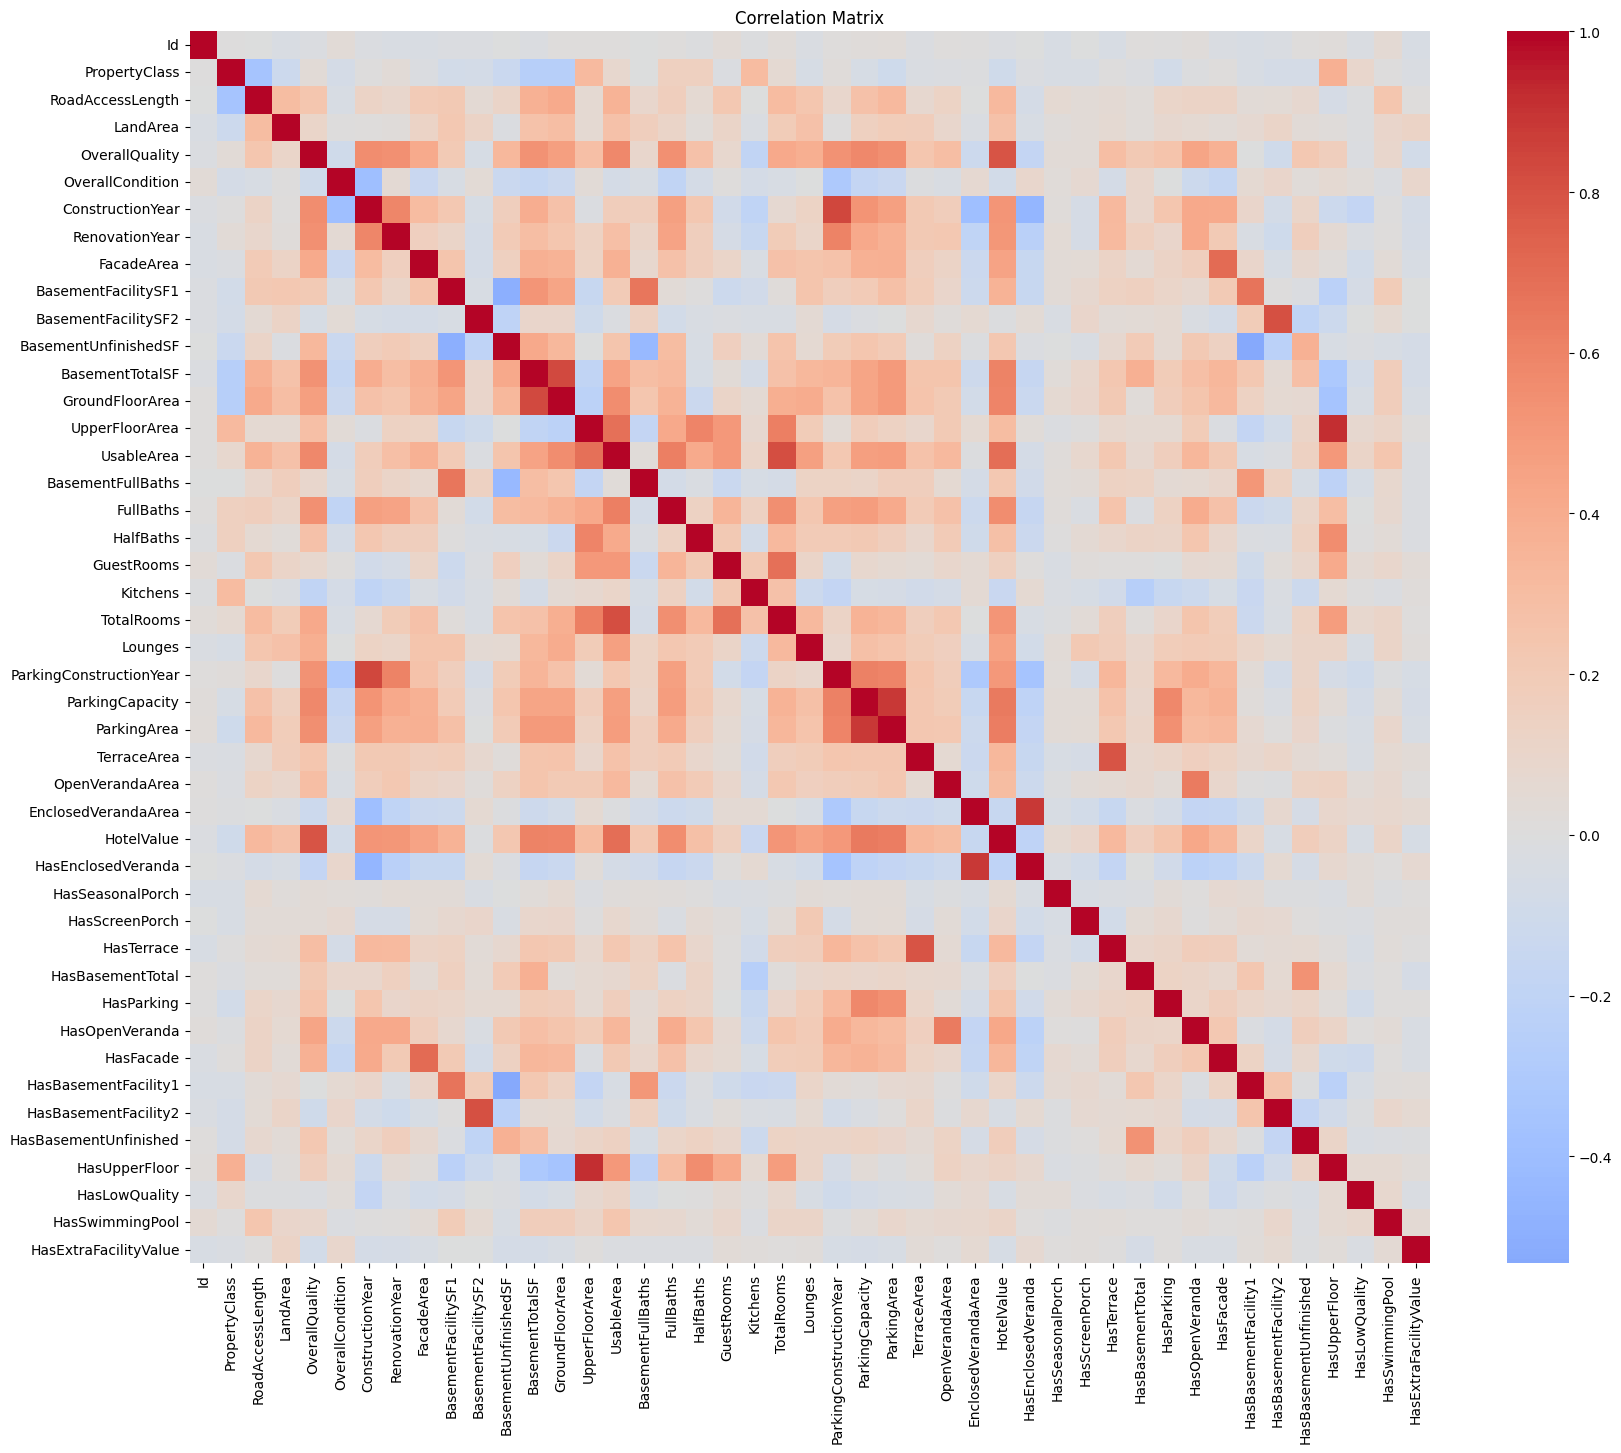

Highly correlated pairs (>0.75):
OverallQuality <-> HotelValue: 0.788
ConstructionYear <-> ParkingConstructionYear: 0.842
BasementFacilitySF2 <-> HasBasementFacility2: 0.805
BasementTotalSF <-> GroundFloorArea: 0.829
UpperFloorArea <-> HasUpperFloor: 0.911
UsableArea <-> TotalRooms: 0.820
ParkingCapacity <-> ParkingArea: 0.881
TerraceArea <-> HasTerrace: 0.785
EnclosedVerandaArea <-> HasEnclosedVeranda: 0.883
(1200, 84)
(260, 83)


In [12]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
negative_values = (train_df[numeric_cols] < 0).sum()
print("Negative values per column:\n", negative_values[negative_values > 0])

# Check for infinite values
infinite_values = np.isinf(train_df[numeric_cols]).sum()
print("Infinite values per column:\n", infinite_values[infinite_values > 0])

# Visualize
corr_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Find high correlations (excluding diagonal)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.75:  # threshold
            high_corr.append({
                'Feature1': corr_matrix.columns[i],
                'Feature2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

print("Highly correlated pairs (>0.75):")
for pair in high_corr:
    print(f"{pair['Feature1']} <-> {pair['Feature2']}: {pair['Correlation']:.3f}")

train_df=train_df.drop(columns=['ParkingConstructionYear'])
test_df=test_df.drop(columns=['ParkingConstructionYear'])
print(train_df.shape)
print(test_df.shape)

In [13]:
#Encoding categorical columns

ordinal_cols = ['ExteriorQuality', 'ExteriorCondition', 'BasementHeight', 'BasementCondition', 'BasementExposure',
                'HeatingQuality', 'KitchenQuality',
               'LoungeQuality', 'ParkingQuality', 'ParkingCondition']

ordinal_mappings = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Av': 3, 'Fa': 2, 'Mn': 2, 'Po': 1, 'No': 0, 'None': 0}

def encode_ordinal(train_df, test_df, ordinal_cols):
    """
    Encode ordinal columns with proper ordering
    """
    for col in ordinal_cols:
        # Use predefined mapping
        train_df[col] = train_df[col].map(ordinal_mappings)
        test_df[col] = test_df[col].map(ordinal_mappings)
    
    return train_df, test_df

def target_encode(train_df, test_df, col, target='HotelValue', smoothing=10):
    """
    Target encode a categorical column using mean of target
    Includes smoothing to prevent overfitting
    """
    # Calculate global mean from train
    global_mean = train_df[target].mean()
    
    # Calculate mean target per category
    agg = train_df.groupby(col)[target].agg(['mean', 'count'])
    
    # Smoothing: blend category mean with global mean based on sample size
    smoothed_mean = (agg['mean'] * agg['count'] + global_mean * smoothing) / (agg['count'] + smoothing)
    
    # Replace the column directly
    train_df[col] = train_df[col].map(smoothed_mean)
    test_df[col] = test_df[col].map(smoothed_mean)
    
    # Fill unknown categories with global mean
    train_df[col]=train_df[col].fillna(global_mean)
    test_df[col]=test_df[col].fillna(global_mean)
    
    return train_df, test_df

def onehot_encode(train_df, test_df, col):
    """
    One-hot encode a categorical column
    Ensures train and test have same columns
    """
    # One-hot encode
    train_df = pd.get_dummies(train_df, columns=[col], dtype=int, drop_first=True)
    test_df = pd.get_dummies(test_df, columns=[col], dtype=int, drop_first=True)
    
    # Align columns (in case test has categories not in train or vice versa)
    train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)
    
    return train_df, test_df

def encode_all_categoricals(train_df, test_df, ordinal_cols, cardinality_threshold=10):
    """
    Complete encoding pipeline
    
    Parameters:
    - train_df: training dataframe
    - test_df: test dataframe  
    - ordinal_cols: list of ordinal column names
    - cardinality_threshold: if unique values > threshold, use target encoding, else one-hot
    """
    
    # Get all categorical columns
    categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
    
    # Separate nominal from ordinal
    nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]
    
    print(f"Encoding {len(ordinal_cols)} ordinal columns...")
    # 1. Encode ordinal columns
    train_df, test_df = encode_ordinal(train_df, test_df, ordinal_cols)
    
    print(f"\nProcessing {len(nominal_cols)} nominal columns...")
    # 2. Encode nominal columns based on cardinality
    high_cardinality_cols = []
    low_cardinality_cols = []
    
    for col in nominal_cols:
        n_unique = train_df[col].nunique()
        
        if n_unique > cardinality_threshold:
            high_cardinality_cols.append(col)
            print(f"  {col}: {n_unique} unique values -> Target Encoding")
            train_df, test_df = target_encode(train_df, test_df, col)
        else:
            low_cardinality_cols.append(col)
            print(f"  {col}: {n_unique} unique values -> One-Hot Encoding")
            train_df, test_df = onehot_encode(train_df, test_df, col)
    
    print(f"\n✓ Encoding complete!")
    print(f"  - Ordinal encoded: {len(ordinal_cols)}")
    print(f"  - Target encoded: {len(high_cardinality_cols)}")
    print(f"  - One-hot encoded: {len(low_cardinality_cols)}")
    print(f"\nFinal shape - Train: {train_df.shape}, Test: {test_df.shape}")
    
    # Verify no object columns remain
    remaining_objects = train_df.select_dtypes(include=['object']).columns.tolist()
    if remaining_objects:
        print(f"\n⚠ Warning: Still have object columns: {remaining_objects}")
    else:
        print("✓ All categorical columns encoded successfully!")
    
    return train_df, test_df

train_encoded, test_encoded = encode_all_categoricals(
    train_df=train_df.copy(),  # Use .copy() to avoid modifying original
    test_df=test_df.copy(),
    ordinal_cols=ordinal_cols,
    cardinality_threshold=10
)
print("\nTrain columns:", train_encoded.columns.tolist())
print("------------------------------------------------------------------------------------------------")
print("Test columns:", test_encoded.columns.tolist())
print("\nData types:")
print(train_encoded.dtypes.value_counts())

Encoding 10 ordinal columns...

Processing 30 nominal columns...
  ZoningCategory: 5 unique values -> One-Hot Encoding
  ServiceLaneType: 3 unique values -> One-Hot Encoding
  PlotShape: 4 unique values -> One-Hot Encoding
  LandElevation: 4 unique values -> One-Hot Encoding
  PlotConfiguration: 5 unique values -> One-Hot Encoding
  LandSlope: 3 unique values -> One-Hot Encoding
  District: 25 unique values -> Target Encoding
  NearbyTransport1: 9 unique values -> One-Hot Encoding
  NearbyTransport2: 8 unique values -> One-Hot Encoding
  PropertyType: 5 unique values -> One-Hot Encoding
  HotelStyle: 8 unique values -> One-Hot Encoding
  RoofDesign: 6 unique values -> One-Hot Encoding
  RoofMaterial: 7 unique values -> One-Hot Encoding
  ExteriorPrimary: 15 unique values -> Target Encoding
  ExteriorSecondary: 16 unique values -> Target Encoding
  FacadeType: 4 unique values -> One-Hot Encoding
  FoundationType: 6 unique values -> One-Hot Encoding
  BasementFacilityType1: 7 unique valu